# **Renewables Scenario Generation GAN**

Unofficial implementation in PyTorch 2.

Y. Chen, Y. Wang, D. Kirschen and B. Zhang, "Model-Free Renewable Scenario Generation Using Generative Adversarial Networks," in IEEE Transactions on Power Systems, vol. 33, no. 3, pp. 3265-3275, May 2018, doi: 10.1109/TPWRS.2018.2794541.

Notebook Author: https://github.com/haufjan

### **Import**

In [14]:
import os
import csv
from time import gmtime, strftime, time
from itertools import chain
import numpy as np
import torch
from torch import nn, tensor, Tensor
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scipy
from scipy.signal import welch

### **Functions**

In [15]:
def load_wind_data(path_data: str, path_labels: str) -> tuple:
    """
    Load and preprocess solar data and labels for GAN training.
    """
    # Example dataset created for evnet_based GANs wind scenarios generation
    # Data from NREL wind integrated datasets
    with open(f'{path_data}' if path_data.endswith('csv') else f'{path_data}.csv', 'r') as csvfile:
        rows = np.array(list(csv.reader(csvfile)), dtype=float)
    tr_x = []
    m = np.ndarray.max(rows)
    print('\nMax(Wind)', m)

    for x in range(rows.shape[1]):
        train = rows[:-288, x].reshape(-1, 576)
        train = train / m
        tr_x.extend(train)

    tr_x = np.asarray(tr_x)
    print('\nShape tr_x', tr_x.shape)

    with open(f'{path_labels}' if path_labels.endswith('csv') else f'{path_labels}.csv', 'r') as csvfile:
        label = np.array(list(csv.reader(csvfile)), dtype=int)
    print('\nShape label', label.shape)

    return tr_x, label, m

In [16]:
def encode_onehot(X, n: int = None, negative_class: float = 0.0) -> np.ndarray:
    """
    Function for encoding ordinal labels into OneHot representation.

    Args:
        x (array_like): Input labels
        n (int): Set number of ordinal labels otherwise it's inferred from data
        negative_class (float): Default value for non-activated classes
    Returns:
        x_oh (np.ndarray): OneHot encoded labels
    """
    X = np.asarray(X).flatten()
    if n is None:
        n = np.max(X) + 1
    x_oh = np.ones((len(X), n)) * negative_class
    for i in range(len(X)):
        m = X[i]
        x_oh[i,m] = 1
    return x_oh

### **Load Data**

In [17]:
#Load and preprocess the data and labels
tr_x, tr_y, m = load_wind_data(os.path.join('wind.csv'), os.path.join('wind_label.csv'))

#Find number of unique ordinal labels
events_num = len(np.unique(tr_y))


Max(Wind) 16.0

Shape tr_x (9464, 576)

Shape label (9464, 1)


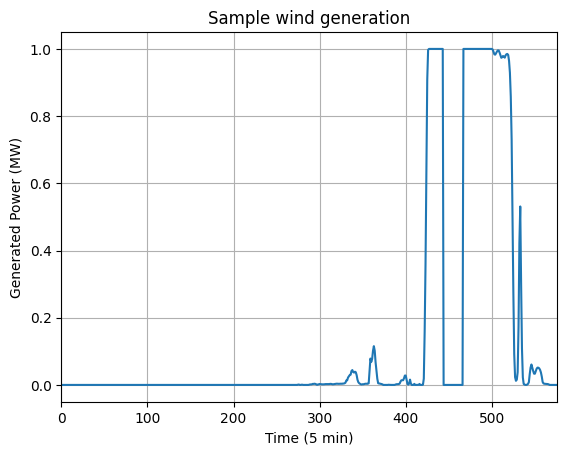

In [18]:
# Plot one sample from the data
fig, ax = plt.subplots()
ax.plot(tr_x[0,:])
ax.set_xlim(0, tr_x.shape[-1])
ax.set_xlabel('Time (5 min)')
ax.set_ylabel('Generated Power (MW)')
ax.set_title('Sample wind generation')
ax.grid(True)

### **Device**

In [19]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print('Current device:', device)

Current device: cuda


### **Networks**

##### **Generator**

In [20]:
class Generator(nn.Module):
    """
    Generator network for the GAN model.
    """
    def __init__(self,
                 batch_size: int = 32,
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_w1: int = 1024,
                 dim_w2: int = 128,
                 dim_w3: int = 64,
                 dim_channel: int = 1,
                 device: str = 'cpu'):
        super().__init__()

        # Attributes
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_w1 = dim_w1
        self.dim_w2 = dim_w2
        self.dim_w3 = dim_w3
        self.dim_channel = dim_channel
        self.device = device

        # Layers
        self.layer1 = nn.Sequential(nn.Linear(dim_z + dim_y, dim_w1, bias=False),
                                    nn.BatchNorm1d(dim_w1, eps=1e-8),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(dim_w1 + dim_y, dim_w2*6*6, bias=False),
                                    nn.BatchNorm1d(dim_w2*6*6, eps=1e-8),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_w2 + dim_y, out_channels=dim_w3, kernel_size=5, stride=2, padding=2, output_padding=1),
                                    nn.BatchNorm2d(dim_w3, eps=1e-8),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_w3 + dim_y, out_channels=dim_channel, kernel_size=5, stride=2, padding=2, output_padding=1),
                                    nn.BatchNorm2d(dim_channel, eps=1e-8))

    def forward(self, z: Tensor, y: Tensor) -> Tensor:
        """
        Forward pass through the generator network.

        Args:
            z (Tensor): Noise
            y (Tensor): OneHot encoded labels
        Returns:
            Tensor: Generated samples
        """
        yb = torch.reshape(y, (self.batch_size, self.dim_y, 1, 1))
        z = torch.cat((z, y), 1)
        h1 = self.layer1(z)
        h1 = torch.cat((h1, y), 1)
        h2 = self.layer2(h1)
        h2 = torch.reshape(h2, (self.batch_size, self.dim_w2, 6, 6))
        h2 = torch.cat((h2, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 6, 6), dtype=torch.float32, device=self.device))), 1)
        h3 = self.layer3(h2)
        h3 = torch.cat((h3, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 12, 12), dtype=torch.float32, device=self.device))), 1)
        h4 = self.layer4(h3)

        return h4

##### **Discriminator**

In [21]:
class Discriminator(nn.Module):
    """
    Discriminator network for the GAN model.
    """
    def __init__(self,
                 batch_size: int = 32,
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_w1: int = 1024,
                 dim_w2: int = 128,
                 dim_w3: int = 64,
                 dim_channel:int = 1,
                 device: str = 'cpu'):
        super().__init__()

        # Attributes
        self.batch_size = batch_size
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_w1 = dim_w1
        self.dim_w2 = dim_w2
        self.dim_w3 = dim_w3
        self.dim_channel = dim_channel
        self.device = device

        # Layers
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=dim_channel + dim_y, out_channels=dim_w3, kernel_size=5, stride=2, padding=2),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=dim_w3 + dim_y, out_channels=dim_w2, kernel_size=5, stride=2, padding=2),
                                    nn.BatchNorm2d(dim_w2, eps=1e-8),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.layer3 = nn.Sequential(nn.Linear(dim_w2*6*6 + dim_y, dim_w1, bias=False),
                                    nn.BatchNorm1d(dim_w1, eps=1e-8),
                                    nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, image: Tensor, y: Tensor) -> Tensor:
        """
        Forward processing of input tensors.

        Args:
            image (Tensor): Generated or real samples
            y (Tensor): OneHot encoded labels
        Returns:
            Tensor: Discriminator output
        """
        yb = torch.reshape(y, (self.batch_size, self.dim_y, 1, 1))
        x = torch.cat((image, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 24, 24), dtype=torch.float32, device=self.device))), 1)
        h1 = self.layer1(x)
        h1 = torch.cat((h1, torch.mul(yb, torch.ones((self.batch_size, self.dim_y, 12, 12), dtype=torch.float32, device=self.device))), 1)
        h2 = self.layer2(h1)
        h2 = torch.reshape(h2, (self.batch_size, -1))
        h2 = torch.cat((h2, y), 1)
        h3 = self.layer3(h2)

        return h3

### **Loss Functions**

In [22]:
def generator_cost(raw_gen2: Tensor) -> Tensor:
    """
    Generator loss using Wasserstein distance.
    """
    return -torch.mean(raw_gen2)

In [23]:
def discriminator_cost(raw_real2: Tensor, raw_gen2: Tensor) -> Tensor:
    """
    Discriminator loss using Wasserstein distance.
    """
    return torch.sum(raw_gen2) - torch.sum(raw_real2)

### **GAN**

In [24]:
class GAN(nn.Module):
    """
    Renewables Scenario Generation Generative Adversarial Networks.
    """
    def __init__(self,
                 epochs: int = 5000,
                 batch_size: int = 32,
                 image_shape: tuple | list = (1, 24, 24),
                 dim_y: int = 6,
                 dim_z: int = 100,
                 dim_w1: int = 1024,
                 dim_w2: int = 128,
                 dim_w3: int = 64,
                 dim_channel: int = 1,
                 learning_rate: float = 1e-4,
                 device: str = 'cpu'):
        super().__init__()

        # Attributes
        self.epochs = epochs
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.dim_w1 = dim_w1
        self.dim_w2 = dim_w2
        self.dim_w3 = dim_w3
        self.dim_channel = dim_channel
        self.learning_rate = learning_rate
        self.device = device
        self.normal = (0, 0.1)
        self.rng = np.random.default_rng(seed=42)

        # Networks
        self.generator = Generator(batch_size, dim_y, dim_z, dim_w1, dim_w2, dim_w3, dim_channel, device=device)
        self.discriminator = Discriminator(batch_size, dim_y, dim_z, dim_w1, dim_w2, dim_w3, dim_channel, device=device)

        # Optimizers
        self.optimizer_g = torch.optim.RMSprop(list(self.generator.parameters()), lr=learning_rate, weight_decay=0, momentum=0)
        self.optimizer_d = torch.optim.RMSprop(list(self.discriminator.parameters()), lr=learning_rate, weight_decay=0, momentum=0)

        # Initialization of weights
        for weights in chain(self.generator.parameters(), self.discriminator.parameters()):
            torch.nn.init.normal_(weights, mean=0.0, std=0.02)

        # Auxiliary
        self.fitting_time = None

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Train the GAN model on the provided data and labels.
        """
        self.fitting_time = time()
        iterations = 0
        # Control balance of training discriminator vs generator
        k = 4

        p_real = []
        p_fake = []
        discrim_loss = []
        gen_loss = []

        for epoch in range(self.epochs):
            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', epoch + 1)

            index = np.arange(len(y))
            self.rng.shuffle(index)
            x = x[index]
            y = y[index]
            y2 = encode_onehot(y, n=self.dim_y)

            for start, end in zip(range(0, len(y), self.batch_size), range(self.batch_size, len(y), self.batch_size)):
                xs = x [start:end].reshape([-1, *self.image_shape])
                ys = y2[start:end]

                zs = self.rng.normal(self.normal[0], self.normal[1], size=(self.batch_size, self.dim_z)).astype(np.float32)

                xs = tensor(xs, dtype=torch.float32, device=self.device)
                ys = tensor(ys, dtype=torch.float32, device=self.device)
                zs = tensor(zs, dtype=torch.float32, device=self.device)

                self.train()
                if iterations % k == 0:
                    self.optimizer_g.zero_grad()

                    h4 = self.generator(zs, ys)
                    image_gen = nn.Sigmoid()(h4)
                    raw_gen2 = self.discriminator(image_gen, ys)
                    p_gen_val = torch.mean(raw_gen2)

                    gen_loss_val = generator_cost(raw_gen2)

                    raw_real2 = self.discriminator(xs, ys)
                    p_real_val = torch.mean(raw_real2)

                    discrim_loss_val = discriminator_cost(raw_real2, raw_gen2)

                    gen_loss_val.backward()
                    self.optimizer_g.step()
                else:
                    self.optimizer_d.zero_grad()

                    h4 = self.generator(zs, ys)
                    image_gen = nn.Sigmoid()(h4)
                    raw_gen2 = self.discriminator(image_gen, ys)
                    p_gen_val = torch.mean(raw_gen2)

                    gen_loss_val = generator_cost(raw_gen2)

                    raw_real2 = self.discriminator(xs, ys)
                    p_real_val = torch.mean(raw_real2)

                    discrim_loss_val = discriminator_cost(raw_real2, raw_gen2)

                    discrim_loss_val.backward()
                    self.optimizer_d.step()

                p_real.append(p_real_val.cpu().item())
                p_fake.append(p_gen_val.cpu().item())
                discrim_loss.append(discrim_loss_val.cpu().item())
                gen_loss.append(gen_loss_val.cpu().item())

                if iterations % 1000 == 0:
                    print('Iterations',
                          iterations,
                          '| Average P(real):', f'{p_real_val.cpu().item():12.9f}',
                          '| Average P(fake):', f'{p_gen_val.cpu().item():12.9f}',
                          '| Discriminator loss:', f'{discrim_loss_val.cpu().item():12.9f}',
                          '| Generator loss:', f'{gen_loss_val.cpu().item():12.9f}')

                iterations += 1

        self.fitting_time = np.round(time() - self.fitting_time, 3)
        print('\nElapsed Training Time: ' + strftime('%Hh %Mmin %Ss', gmtime(self.fitting_time)))

        # Plotting
        fig, ax = plt.subplots()
        ax.plot(p_real, label='real')
        ax.plot(p_fake, label='fake')
        ax.legend()
        ax.set_xlim(0, len(p_real))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Wasserstein Distance')
        ax.grid(True)
        fig.show()

        fig, ax = plt.subplots()
        ax.plot(discrim_loss)
        ax.set_xlim(0, len(discrim_loss))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Discriminator Loss')
        ax.grid(True)
        fig.show()

    def predict(self) -> np.ndarray:
        """
        Generate data using the trained generator conditioned on randomly sampled labels.
        """
        self.eval()
        with torch.no_grad():
            generated_labels = self.rng.integers(self.dim_y, size=(self.batch_size, 1), dtype=np.int8)
            y_np_sample = encode_onehot(generated_labels, n=self.dim_y)
            zs = self.rng.normal(self.normal[0], self.normal[1], size=[self.batch_size, self.dim_z]).astype(np.float32)

            y_np_sample = tensor(y_np_sample, dtype=torch.int8, device=self.device)
            zs = tensor(zs, dtype=torch.float32, device=self.device)

            generated_samples = nn.Sigmoid()(self.generator(zs, y_np_sample))

        # Image shape 24x24 = 576
        generated_samples = generated_samples.reshape([-1, 576])

        return generated_samples.cpu().detach().numpy(), generated_labels

### **Instantiate GAN Model**

In [25]:
# Create GAN model instance with specified parameters
model = GAN(epochs=300,
            dim_y=events_num,
            learning_rate=1e-3,
            device=device).to(device)

### **Train GAN Model**

Iterations 0 | Average P(real):  0.009135531 | Average P(fake):  0.009144697 | Discriminator loss:  0.300354004 | Generator loss: -0.009144697
Iterations 1000 | Average P(real):  0.142887294 | Average P(fake):  0.065207317 | Discriminator loss: -2545.417480469 | Generator loss: -0.065207317
Iterations 2000 | Average P(real):  0.258283943 | Average P(fake):  0.140279740 | Discriminator loss: -3866.761718750 | Generator loss: -0.140279740
Iterations 3000 | Average P(real):  0.378661692 | Average P(fake):  0.182350039 | Discriminator loss: -6432.740234375 | Generator loss: -0.182350039
Iterations 4000 | Average P(real):  0.425524950 | Average P(fake):  0.288812995 | Discriminator loss: -4479.777343750 | Generator loss: -0.288812995
Iterations 5000 | Average P(real):  0.672701120 | Average P(fake):  0.390631050 | Discriminator loss: -9242.872070312 | Generator loss: -0.390631050
Iterations 6000 | Average P(real):  0.790982246 | Average P(fake):  0.350764275 | Discriminator loss: -14425.062

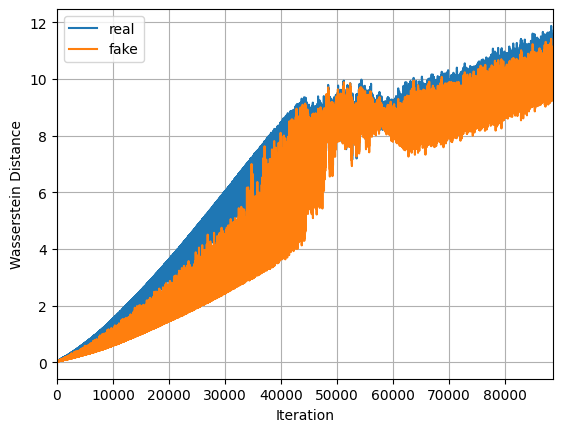

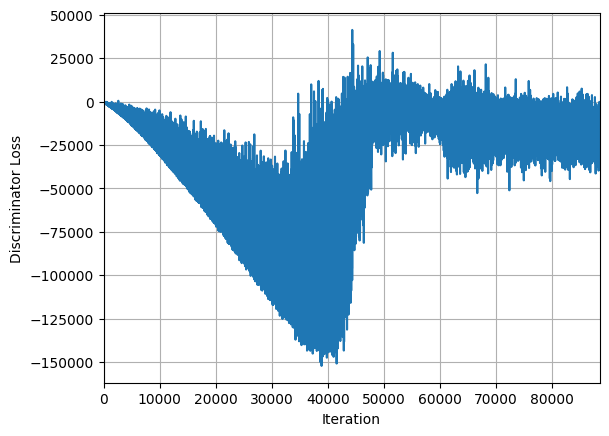

In [26]:
# Start training
model.fit(tr_x, tr_y)

### **Generate Data**

In [27]:
# Sample a set of labels and generate data
data_gen, labels_sampled = model.predict()

# Rescaling
data_real = tr_x*m
data_gen = data_gen*m

### **Evaluation**

In [30]:
def visualize_resuls(data_real: np.ndarray, data_gen: np.ndarray, labels: np.ndarray, labels_sampled: np.ndarray) -> None:
    # Find unique ordinal labels within samples
    labels_unique = np.unique(labels_sampled)

    # Sampling frequency of 5 min resolution in Hz
    fs = 1/(60*5)

    fig, ax = plt.subplots(len(labels_unique), 2, figsize=(8, 2*len(labels_unique)), layout='constrained')
    for i, label in enumerate(labels_unique):
        # Get indices to organize by ordinal labels
        indices_real, _ = np.nonzero(labels == label)
        indices_gen, _ = np.nonzero(labels_sampled == label)

        # Left column
        ax[i,0].fill_between(np.arange(0, data_real.shape[-1]), np.max(data_real[indices_real], 0), np.min(data_real[indices_real], 0), alpha=0.2)
        ax[i,0].plot(np.mean(data_real[indices_real], 0))
        ax[i,0].plot(data_gen[indices_gen].transpose(), alpha=0.5)
        ax[i,0].set_xlabel('Time (5 min)')
        ax[i,0].set_ylabel('Generated Power (MW)')
        ax[i,0].set_xlim(0, data_gen.shape[-1])
        ax[i,0].grid(True)

        # Right column
        f_real, pden_real = welch(data_real[indices_real,:], fs, nperseg=128)
        f_gen, pden_gen = welch(data_gen[indices_gen,:], fs, nperseg=128)
        ax[i,1].semilogy(f_real, np.mean(pden_real, 0))
        ax[i,1].fill_between(f_real, np.max(pden_real, 0), np.min(pden_real, 0), alpha=0.2)
        ax[i,1].semilogy(f_gen, pden_gen.transpose(), alpha=0.5)
        ax[i,1].set_xlim(0, max(f_real))
        ax[i,1].ticklabel_format(axis='x', style='sci', scilimits=(0, max(f_real)))
        ax[i,1].set_xlabel('Frequency (Hz)')
        ax[i,1].set_ylabel(r'PSD ($\frac{MW^2}{Hz}$)')
        ax[i,1].grid(True)

    # fig.savefig('generated_data.png', bbox_inches='tight')
    fig.show()

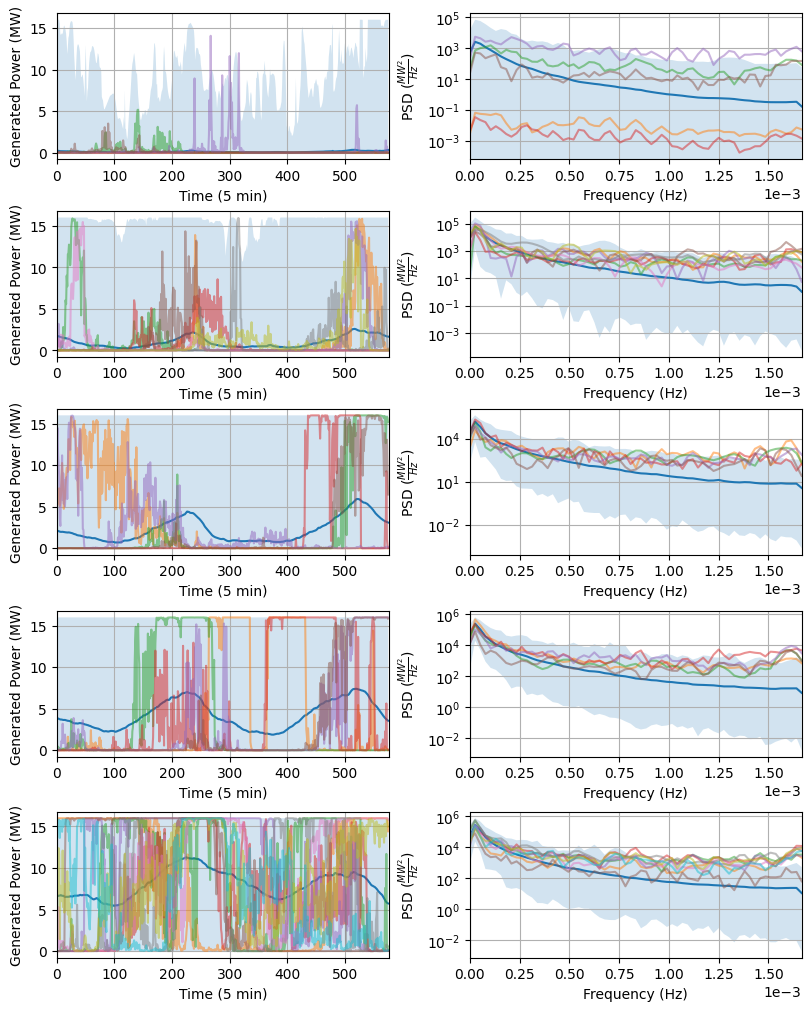

In [31]:
visualize_resuls(data_real, data_gen, tr_y, labels_sampled)
plt.show()